In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pyaudio
import numpy as np
from scipy.signal import iirnotch, filtfilt, butter
from glob import glob
# Load Data

In [4]:
#data, header = pyxdf.load_xdf('')
file_path = '/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/Data/real_subjects/sub-P5149890/sub-P5149890_ses-S001_task-CUNY_run-001_mobi.xdf'
data, header = pyxdf.load_xdf(file_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

['EGI NetAmp 0',
 'OpenSignals',
 'WebcamStream',
 'Tobii',
 'Stimuli_Markers',
 'Microphone']

In [31]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000

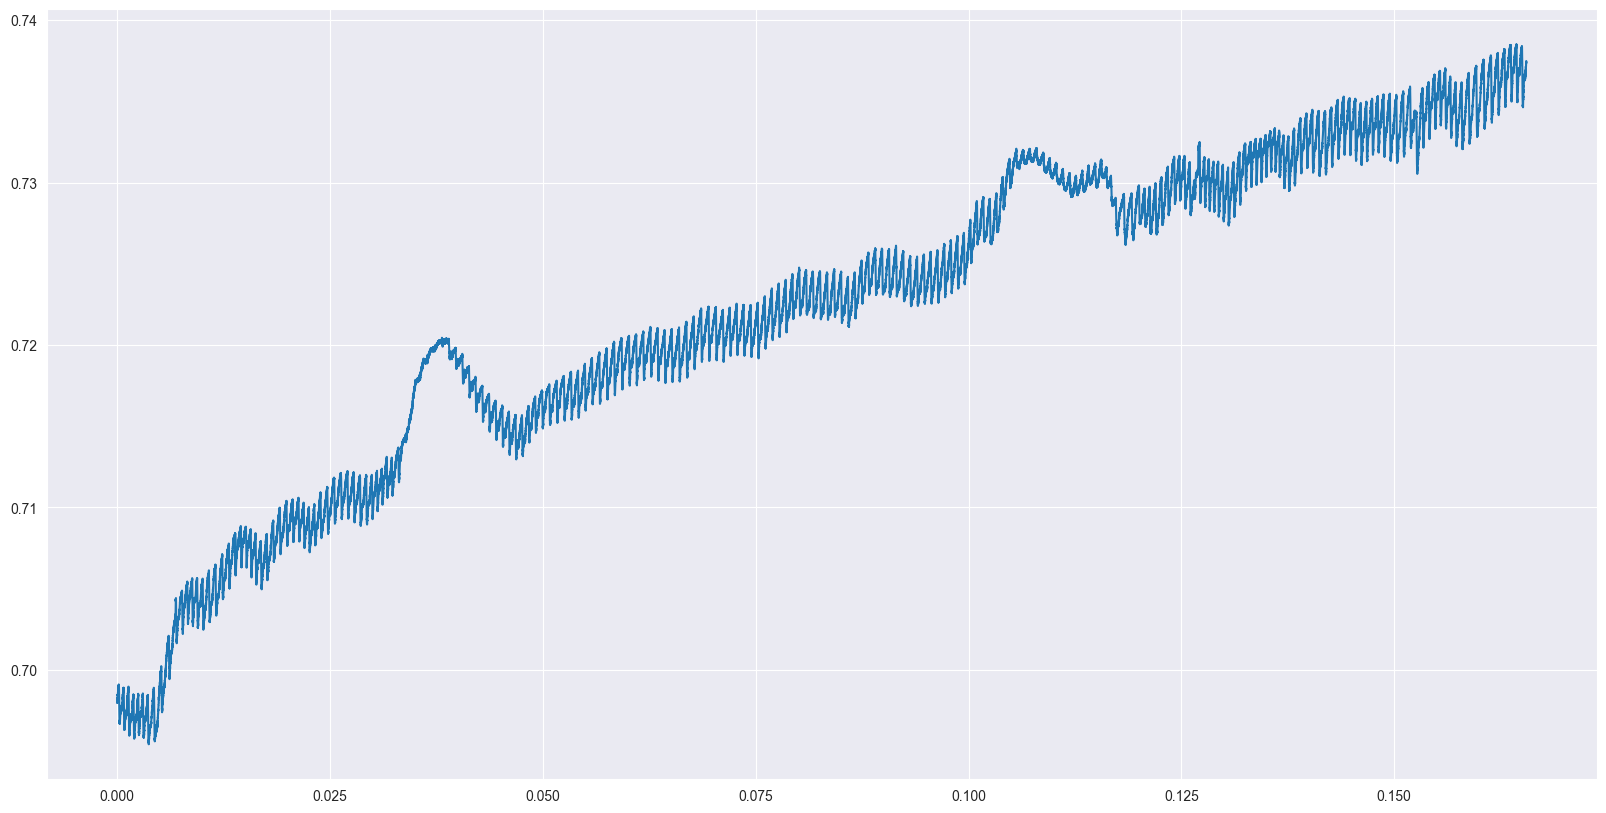

In [4]:
# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(ps_df['time'], ps_df['fSpO22'], label='SpO2')

In [37]:
ps_df#['fSpO25'].describe()

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
0,584730.0,-0.02527,0.12974,3.5606,0.61432,1.14860,100.0,767416.354978,0.000000
1,584731.0,-0.02545,0.11563,3.5599,0.61450,1.14857,100.0,767416.356644,0.000002
2,584732.0,-0.02545,0.10162,3.5591,0.61445,1.14849,100.0,767416.358310,0.000003
3,584733.0,-0.02563,0.09003,3.5587,0.61439,1.14906,100.0,767416.359977,0.000005
4,584734.0,-0.02582,0.08104,3.5599,0.61382,1.14873,100.0,767416.361643,0.000007
...,...,...,...,...,...,...,...,...,...
900443,1485173.0,0.38672,-0.10476,6.6490,0.59573,1.19637,96.0,768916.793591,1.500439
900444,1485174.0,0.38855,-0.10359,6.6513,0.59614,1.19628,96.0,768916.795257,1.500440
900445,1485175.0,0.38983,-0.09425,6.6505,0.59614,1.19628,96.0,768916.796923,1.500442
900446,1485176.0,0.39130,-0.08949,6.6483,0.59628,1.19586,96.0,768916.798590,1.500444


In [38]:
# converting units from uA 
ir_signal = ps_df['fSpO24'][40000:45000]
red_signal = ps_df['fSpO23'][40000:45000]
sr = PS['info']['effective_srate'] # Sampling rate
resolution = 16 # Resolution (number of available bits)
gain = 1 #MOhm
signal_red_i_pd = (1.2 * red_signal) / 2**resolution
signal_infrared_i_pd = (1.2 * ir_signal) / 2**resolution

ValueError: x and y must have same first dimension, but have shapes (5000,) and (500,)

<Figure size 4000x2000 with 0 Axes>

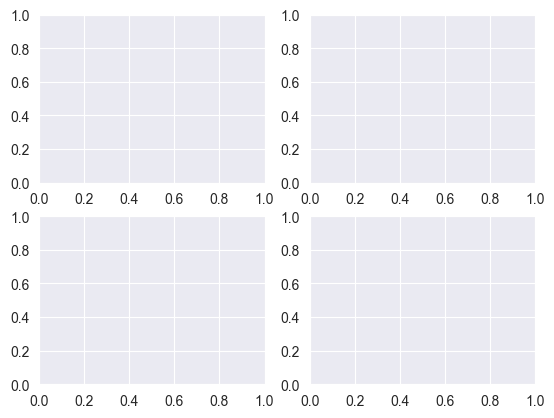

In [7]:
# plot the raw red and ir signals and the converted i_pd signals in four plots
plt.figure(figsize=(40, 20))
f, ax = plt.subplots(2, 2)
ax[0,0].plot(ps_df['time'][40000:45000], red_signal, label='Red Signal')
plt.title('Raw Red Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
#plt.legend()

ax[0,1].plot(ps_df['time'][40000:45000], ir_signal, label='Red Signal' )
plt.title('Raw IR Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
#plt.legend()

ax[1,0].plot(ps_df['time'][40000:45000], signal_red_i_pd, label='Red Signal Voltage')
plt.title('converted IR Signal')
plt.xlabel('Time [s]')
plt.ylabel('V')
#plt.legend()

ax[1,1].plot(ps_df['time'][40000:45000], signal_infrared_i_pd, label='IR Signal Voltage')
plt.title('converted IR Signal')
plt.xlabel('Time [s]')
plt.ylabel('V')
plt.legend()
plt.tight_layout()

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Simulated signal generation for red and infrared signals
def generate_test_signals(fs, duration, hr, noise_level):
    """
    Generate synthetic red and infrared signals.
    fs: Sampling frequency in Hz
    duration: Duration of the signal in seconds
    hr: Heart rate in beats per minute (used to simulate AC component)
    noise_level: Standard deviation of noise to add to the signal
    """
    t = np.linspace(0, duration, int(fs*duration))
    f_hr = hr / 60.0  # Convert heart rate to Hz (pulses per second)

    # DC component (constant value representing tissue absorption)
    dc_red = 1.0
    dc_ir = 1.5

    # AC component (sinusoidal wave representing pulsatile changes in blood)
    ac_red = 0.02 * np.sin(2 * np.pi * f_hr * t)
    ac_ir = 0.03 * np.sin(2 * np.pi * f_hr * t)

    # Add noise to the signal
    noise_red = noise_level * np.random.normal(size=len(t))
    noise_ir = noise_level * np.random.normal(size=len(t))

    # Red and infrared signals
    red_signal = dc_red + ac_red + noise_red
    ir_signal = dc_ir + ac_ir + noise_ir

    return t, red_signal, ir_signal

# Design filters: low-pass for DC, high-pass for AC, and optional bandpass
def butter_filter(data, cutoff, fs, order=5, btype='low'):
    """
    Apply Butterworth filter (low-pass, high-pass, or bandpass).
    data: Input signal
    cutoff: Cutoff frequency (for low/high-pass) or frequencies (for bandpass)
    fs: Sampling frequency
    order: Filter order
    btype: 'low' for low-pass, 'high' for high-pass, or 'band' for bandpass
    """
    nyquist = 0.5 * fs
    normal_cutoff = np.array(cutoff) / nyquist
    [b, a] = butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# Parameters
'''
fs = 100  # Sampling frequency in Hz
duration = 5  # Signal duration in seconds
hr = 75  # Heart rate in beats per minute
noise_level = 0.01  # Standard deviation of noise
'''

fs = PS['info']['effective_srate']
duration = ps_df['time'].iloc[-1]
hr = 75
noise_level = 0.01



In [40]:
#t, red_signal, ir_signal = generate_test_signals(fs, duration, hr, noise_level)
sr = PS['info']['effective_srate'] # Sampling rate
resolution = 16 # Resolution (number of available bits)
gain = 1 #MOhm
#signal_red_i_pd = (1.2 * red_signal) / 2**resolution
#signal_infrared_i_pd = (1.2 * ir_signal) / 2**resolution

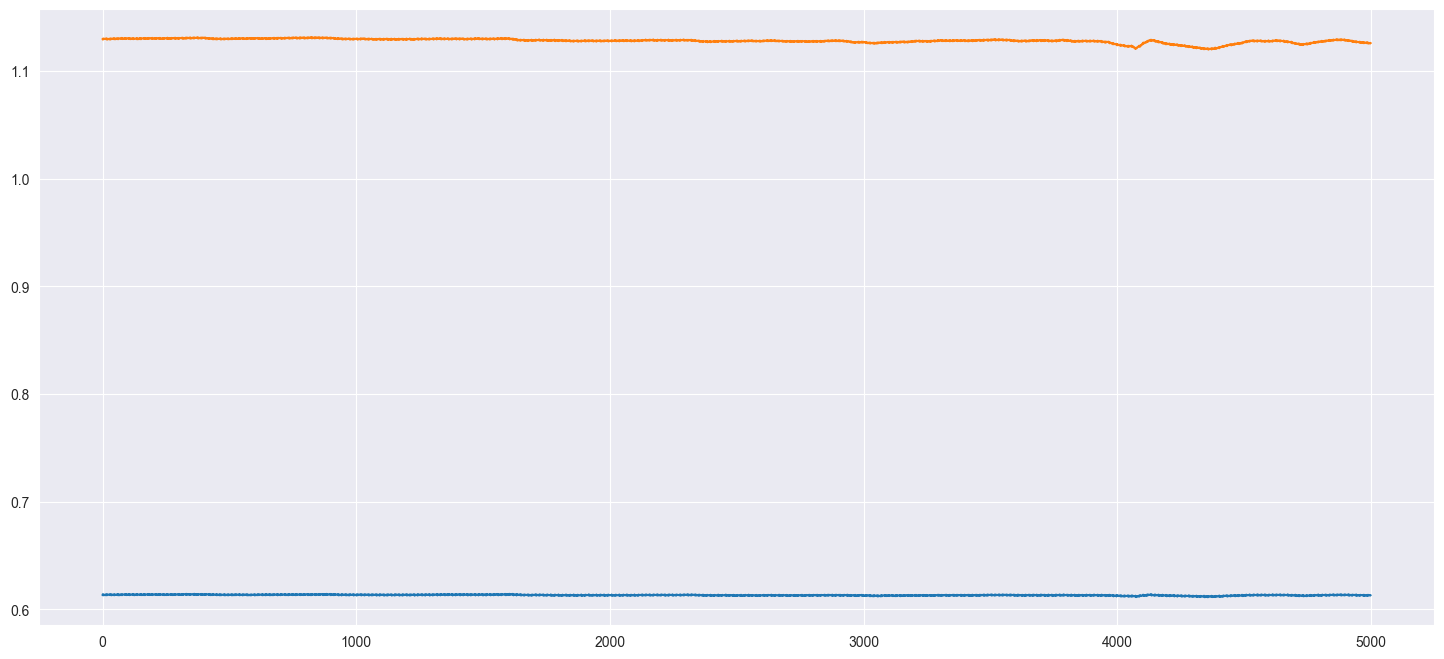

In [41]:
plt.figure(figsize=(18, 8))
t = range(len(signal_infrared_i_pd))
plt.plot(t, red_signal, label='Original Red Signal')
plt.plot(t, ir_signal, label='Original IR Signal')

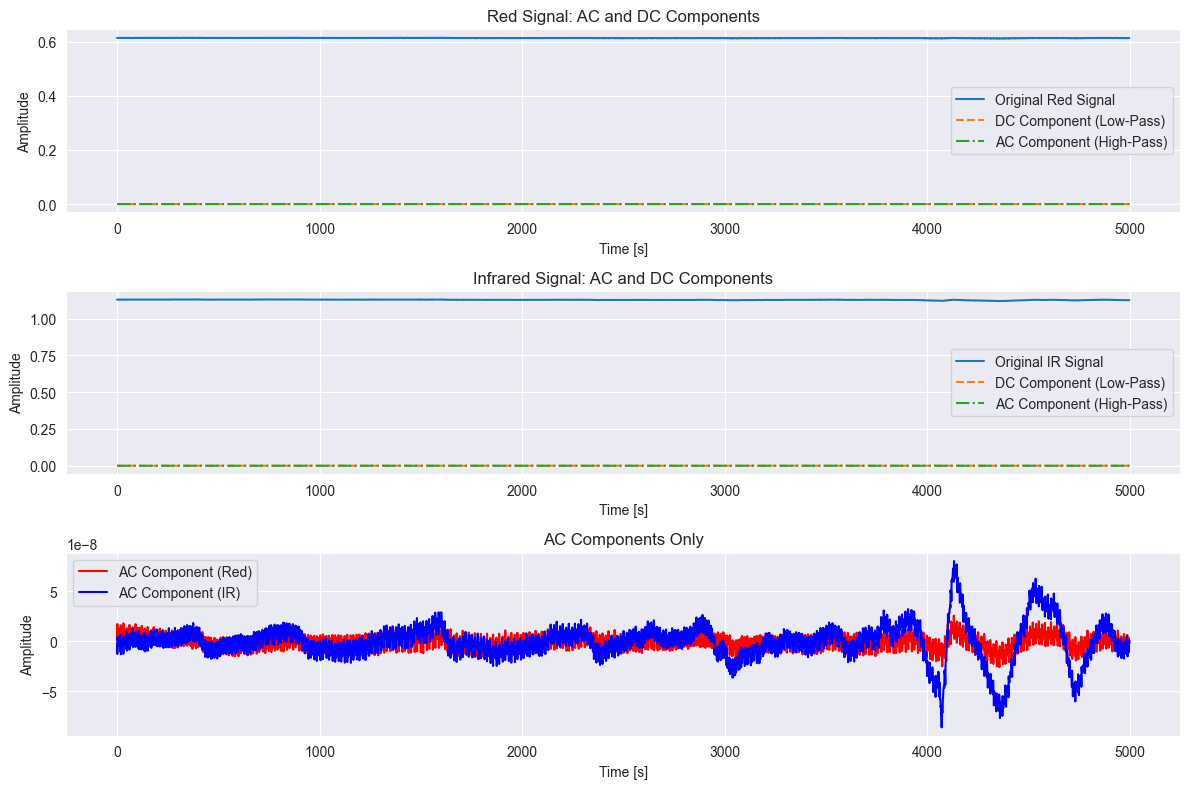

In [42]:

# Generate test signals
#t = ps_df['time']
#red_signal = ps_df['fSpO22']
#ir_signal = ps_df['fSpO21']


# Apply filters to extract AC and DC components
# Low-pass filter for DC component (cutoff frequency ~1 Hz)
dc_red = butter_filter(signal_red_i_pd, cutoff=1.0, fs=fs, order=5, btype='low')
dc_ir = butter_filter(signal_infrared_i_pd, cutoff=1.0, fs=fs, order=5, btype='low')

# High-pass filter for AC component (cutoff frequency ~0.5 Hz)
ac_red = butter_filter(signal_red_i_pd, cutoff=0.5, fs=fs, order=5, btype='high')
ac_ir = butter_filter(signal_infrared_i_pd, cutoff=0.5, fs=fs, order=5, btype='high')

# Plot the results
plt.figure(figsize=(12, 8))

# Plot original Red signal
plt.subplot(3, 1, 1)
plt.plot(t, red_signal, label='Original Red Signal')
plt.plot(t, dc_red, label='DC Component (Low-Pass)', linestyle='--')
plt.plot(t, ac_red, label='AC Component (High-Pass)', linestyle='-.')
plt.title('Red Signal: AC and DC Components')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

# Plot original IR signal
plt.subplot(3, 1, 2)
plt.plot(t, ir_signal, label='Original IR Signal')
plt.plot(t, dc_ir, label='DC Component (Low-Pass)', linestyle='--')
plt.plot(t, ac_ir, label='AC Component (High-Pass)', linestyle='-.')
plt.title('Infrared Signal: AC and DC Components')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

# Plot AC components only
plt.subplot(3, 1, 3)
plt.plot(t, ac_red, label='AC Component (Red)', color='r')
plt.plot(t, ac_ir, label='AC Component (IR)', color='b')
plt.title('AC Components Only')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

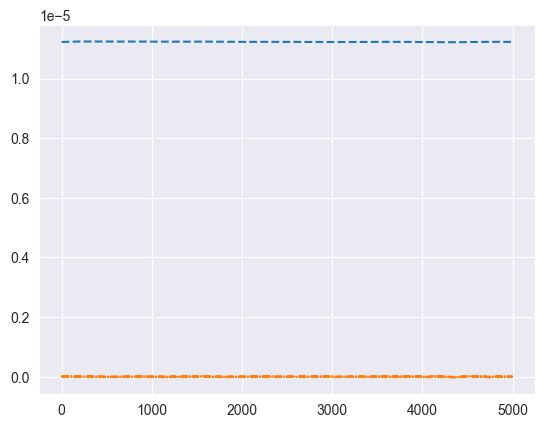

In [43]:
plt.plot(t, dc_red, label='DC Component (Low-Pass)', linestyle='--')
plt.plot(t, ac_red, label='AC Component (High-Pass)', linestyle='-.')

In [44]:
R = (ac_red/dc_red)/(ac_ir/dc_ir)
R

array([-0.8284052 , -2.47102902, -2.46094996, ..., -0.4928392 ,
       -3.3745494 ,  2.0464142 ])

Text(0, 0.5, 'SpO2')

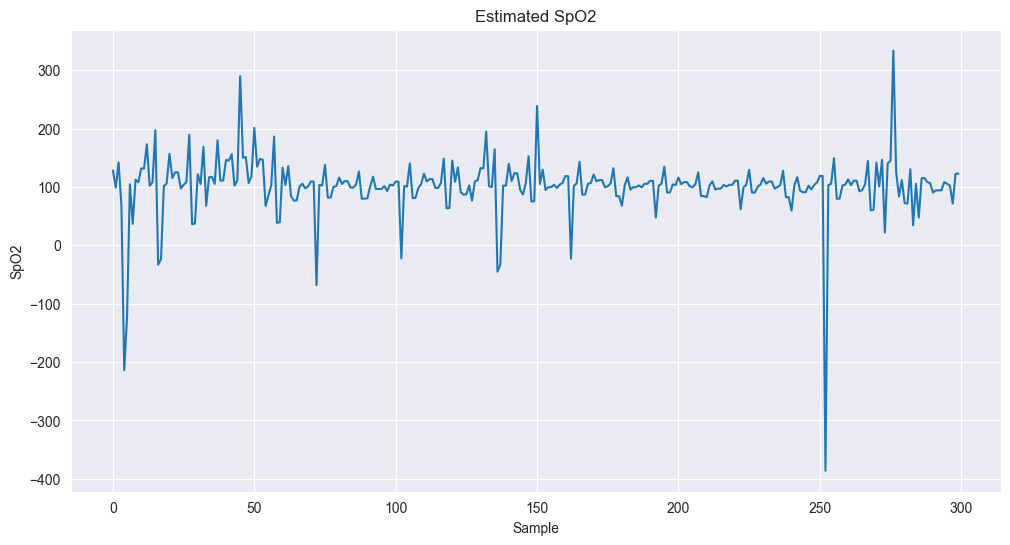

In [55]:
spo2 = 110 - 25 * R

# remove outliers from the spo2 signal 
filtered_spo2 = spo2[(spo2 >= np.quantile(spo2, 0.15)) & (spo2 <= np.quantile(spo2, 0.85))]
plt.figure(figsize=(12, 6))
plt.plot(spo2[3700:4000])
#plt.ylim([50, 200])
plt.title('Estimated SpO2')
plt.xlabel('Sample')
plt.ylabel('SpO2')

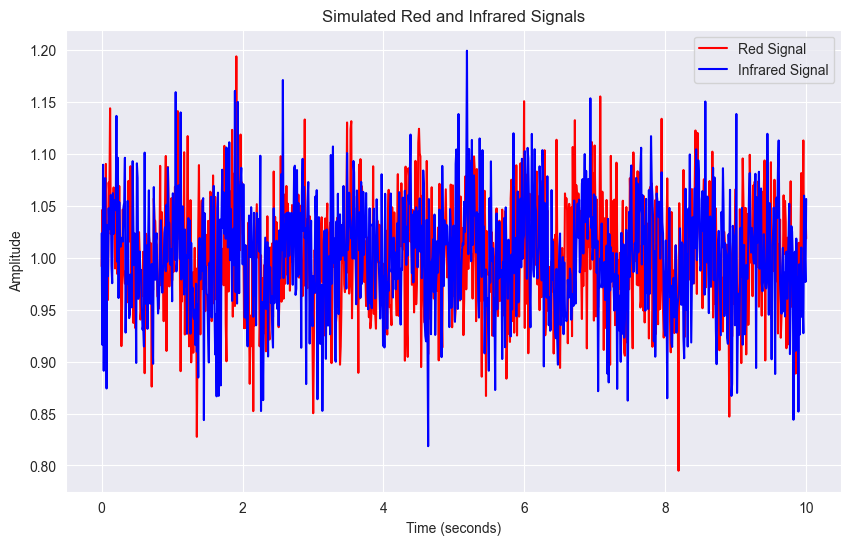

In [30]:
# Simulation parameters
time = np.linspace(0, 10, 1000)  # 10 seconds sampled at 100Hz
heart_rate = 1.2  # Heart rate in Hz (72 bpm)
noise_level = 0.05  # Noise level for the signals

# Signal generation
def simulate_signal(ac_amplitude, dc_value, heart_rate, time, noise_level=0.05):
    # AC component: sine wave to simulate the pulsatile part
    ac_component = ac_amplitude * np.sin(2 * np.pi * heart_rate * time)
    # DC component: constant value representing non-pulsatile part
    dc_component = dc_value
    # Add some noise to make it more realistic
    noise = noise_level * np.random.randn(len(time))
    # Total signal
    return ac_component + dc_component + noise

# Simulate red and infrared signals
ac_red_amplitude = 0.02  # AC amplitude for red
ac_ir_amplitude = 0.03   # AC amplitude for infrared
dc_red_value = 1.0       # DC value for red
dc_ir_value = 1.0        # DC value for infrared

red_signal = simulate_signal(ac_red_amplitude, dc_red_value, heart_rate, time, noise_level)
ir_signal = simulate_signal(ac_ir_amplitude, dc_ir_value, heart_rate, time, noise_level)

# Calculate AC and DC components (simple approach, averaging)
def extract_ac_dc(signal):
    dc_component = np.mean(signal)
    ac_component = np.max(signal) - np.min(signal)
    return ac_component, dc_component

# Extract AC and DC components for both red and infrared signals
ac_red, dc_red = extract_ac_dc(red_signal)
ac_ir, dc_ir = extract_ac_dc(ir_signal)

# Calculate the ratio of ratios (R)
R = (ac_red / dc_red) / (ac_ir / dc_ir)

# Use empirical formula to estimate SpO2 (typical values A=110, B=25)
A, B = 110, 25
SpO2 = A - B * R

# Plot the signals
plt.figure(figsize=(10, 6))
plt.plot(time, red_signal, label="Red Signal", color='red')
plt.plot(time, ir_signal, label="Infrared Signal", color='blue')
plt.title("Simulated Red and Infrared Signals")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [50]:
plt.plot(SpO2

82.49946730250848

# Sample data provided by Bioplux


In [63]:
# read the h5 file
import h5py
import numpy as np

# read the file from path
file_path = "/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/Data/biosignalsplux-SampleSpO2/SampleSpO2.h5"
f = h5py.File(file_path, 'r')
# get the data from the file
data = f['00:07:80:79:6F:DB']
# get the keys of the data
keys = list(data.keys())
# get the data from the keys
red = np.array(data[keys[0]])
ir = np.array(data[keys[1]])

In [67]:
data['raw']

<HDF5 group "/00:07:80:79:6F:DB/raw" (3 members)>

In [62]:
f.keys()

<KeysViewHDF5 ['00:07:80:79:6F:DB']>